In [1]:
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader

In [2]:
dataset = omniglot("data", ways=5, shots=5, test_shots=15, meta_train=True, download=True)
dataloader = BatchMetaDataLoader(dataset, batch_size=16, num_workers=4)

In [3]:
for batch in dataloader:
    train_inputs, train_targets = batch["train"]
    print('Train inputs shape: {0}'.format(train_inputs.shape))    # (16, 25, 1, 28, 28)
    print('Train targets shape: {0}'.format(train_targets.shape))  # (16, 25)

    test_inputs, test_targets = batch["test"]
    print('Test inputs shape: {0}'.format(test_inputs.shape))      # (16, 75, 1, 28, 28)
    print('Test targets shape: {0}'.format(test_targets.shape))    # (16, 75)
    break

Train inputs shape: torch.Size([16, 25, 1, 28, 28])
Train targets shape: torch.Size([16, 25])
Test inputs shape: torch.Size([16, 75, 1, 28, 28])
Test targets shape: torch.Size([16, 75])


In [6]:
import matplotlib.pyplot as plt

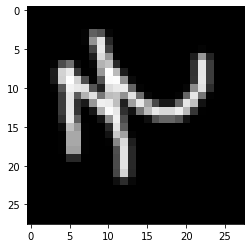

In [11]:
plt.imshow(train_inputs[0][0][0].data.numpy(),cmap="gray")

In [15]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import logging

from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters


In [16]:
import torch.nn as nn
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d,
                               MetaBatchNorm2d, MetaLinear)

In [17]:
def conv3x3(in_channels, out_channels, **kwargs):
    return MetaSequential(
        MetaConv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        MetaBatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [18]:
class ConvolutionalNeuralNetwork(MetaModule):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = MetaSequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        self.classifier = MetaLinear(hidden_size, out_features)

    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits

In [19]:
from collections import OrderedDict


def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points
    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.
    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [21]:
logger = logging.getLogger(__name__)

In [24]:
class ARGS():
    folder = ""
    num_shots = 5
    num_ways = 5
    first_order = None
    step_size = 0.4
    hidden_size = 64
    output_folder = None
    batch_size = 16
    num_batches = 100
    num_workers = 1
    download = True
    use_cuda = True
    device = torch.device('cuda' if use_cuda
        and torch.cuda.is_available() else 'cpu')
    

In [25]:
args = ARGS()

In [26]:
logger.warning('This script is an example to showcase the MetaModule and '
                   'data-loading features of Torchmeta, and as such has been '
                   'very lightly tested. For a better tested implementation of '
                   'Model-Agnostic Meta-Learning (MAML) using Torchmeta with '
                   'more features (including multi-step adaptation and '
                   'different datasets), please check `https://github.com/'
                   'tristandeleu/pytorch-maml`.')

This script is an example to showcase the MetaModule and data-loading features of Torchmeta, and as such has been very lightly tested. For a better tested implementation of Model-Agnostic Meta-Learning (MAML) using Torchmeta with more features (including multi-step adaptation and different datasets), please check `https://github.com/tristandeleu/pytorch-maml`.


In [28]:
dataset = omniglot(args.folder,
                       shots=args.num_shots,
                       ways=args.num_ways,
                       shuffle=True,
                       test_shots=15,
                       meta_train=True,
                       download=True)